In [19]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from evaluation import evaluate

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [20]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "./data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [21]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [22]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [23]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [24]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=time_filtering, # for cnn, time filtering made more sense, and gave better results
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=time_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=512,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

### Baseline: CNN Model

In this section, we define two convolutional neural network (CNN) architectures as simple baselines for EEG signal classification. Both models operate on 1D input data with 19 channels. The larger model (`EEGCNN`) consists of three convolutional blocks followed by a fully connected layer, while the smaller variant (`EEGCNN_Small`) uses only two blocks for a more lightweight design.

Each block includes convolution, batch normalization, ReLU activation, and pooling. The final output is reduced to a single prediction through global pooling, dropout, and a linear layer. 

After experimenting with both versions, we found that the simpler `EEGCNN_Small` model actually outperformed the larger one, suggesting that in this case, a more compact architecture is sufficient and potentially better suited for our task.


In [25]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels=19):
        super().__init__()
        self.cnn = nn.Sequential(
            # Convolutional layers with BatchNorm and ReLU activations
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
        )
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, T, C] → [B, C, T]
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [26]:
class EEGCNN_Small(nn.Module):
    def __init__(self, input_channels=19):
        super().__init__()
        self.cnn = nn.Sequential(
            # Convolutional layers with BatchNorm and ReLU activations
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Second convolutional layer - only 2 allowing for a smaller model
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Global average pooling
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = self.fc(x)
        return x

### Training the CNN Model with Early Stopping

We train the selected `EEGCNN_Small` model using a weighted binary classification loss to address the class imbalance in the dataset. The model is trained on GPU (if available) and optimized using the Adam optimizer.

A weight of 4 is applied to the positive class in `BCEWithLogitsLoss`, ensuring that the minority class has a stronger influence during training.

Key elements of the training loop:
- Training and validation are performed over a maximum of 300 epochs.
- The model tracks training and validation loss, as well as the macro F1 score on the validation set.
- Early stopping is used with a patience of 20 epochs: if the validation F1 score doesn't improve for 20 consecutive epochs, training halts early.
- The best model (based on F1 score) is saved and restored after training ends.

Finally, we visualize:
- Training and validation loss curves.
- F1 score progression across epochs.
- The epoch where the best F1 score was achieved is highlighted with a vertical dashed line.

This setup ensures robustness to class imbalance while preventing overfitting through early stopping.


In [27]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [35]:
model = EEGCNN_Small(input_channels=19).to(device)

# Since the dataset is highly imbalanced, we will use a weighted loss function
class_weight = 4  
# Criterion for binary classification with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 300
patience = 20

train_losses = []
val_losses = []
val_f1_scores = []

best_f1 = 0
epochs_without_improvement = 0
best_model_state = None

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            x_val = x_val.float().to(device)
            y_val = y_val.float().unsqueeze(1).to(device)

            val_logits = model(x_val)
            val_probs = torch.sigmoid(val_logits)
            val_preds = (val_probs > 0.5).int()

            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(loader_val)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)

    # Early Stopping Logic
    if val_f1 > best_f1:
        best_f1 = val_f1
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Restored best model with F1 = {best_f1:.4f}")


Training:  25%|███████████▉                                   | 76/300 [02:47<08:13,  2.20s/it]

Early stopping triggered at epoch 77
Restored best model with F1 = 0.7107


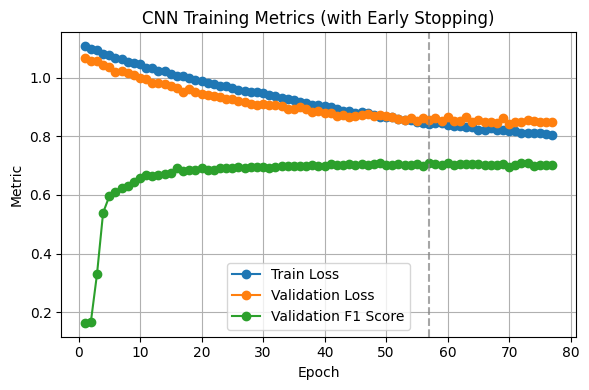

In [36]:
plt.figure(figsize=(6, 4))

epochs_ran = len(train_losses)  # Actual number of epochs before stopping
epoch_range = range(1, epochs_ran + 1)

plt.plot(epoch_range, train_losses, marker="o")
plt.plot(epoch_range, val_losses, marker="o")
plt.plot(epoch_range, val_f1_scores, marker="o")

# Highlight best F1 epoch
best_epoch = val_f1_scores.index(max(val_f1_scores)) + 1
plt.axvline(best_epoch, color='gray', linestyle='--', alpha=0.7, label=f"Best F1 (epoch {best_epoch})")

plt.title("CNN Training Metrics (with Early Stopping)")
plt.legend(["Train Loss", "Validation Loss", "Validation F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.tight_layout()
plt.show()


### Cross-Validation with the `evaluate` Function

The `evaluate` function performs k-fold cross-validation (default: 5 folds) to assess model performance more robustly across different subsets of the dataset. Importantly, the splits are made at the patient level, ensuring that clips from the same patient do not appear in both training and validation sets, which helps prevent data leakage.

For each fold:
- The dataset is split into training and validation clips based on unique patient identifiers.
- A fresh instance of the model is trained from scratch.
- The training loop runs for a fixed number of epochs using the Adam optimizer and a weighted binary cross-entropy loss.
- After training, the model is evaluated on the validation set using macro F1 score, which handles class imbalance.

Finally, the function returns the average and standard deviation of F1 scores across all folds, offering a more stable measure of model performance.

This modular function makes it easy to test different models, loss functions, transforms, or training settings consistently across multiple data splits.

In [37]:
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

evaluate(
    EEGCNN_Small,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=300,
    learning_rate=1e-4,
    model_args={
        "input_channels": 19
    },
    signal_transform=time_filtering,
    batch_size=512,
    prefetch=True,
    criterion=criterion
)

Fold 1/5
Fold 1 F1 Score: 0.6907
Fold 2/5
Fold 2 F1 Score: 0.7035
Fold 3/5
Fold 3 F1 Score: 0.7314
Fold 4/5
Fold 4 F1 Score: 0.6975
Fold 5/5
Fold 5 F1 Score: 0.7174
Cross-Validation Average F1 Score: 0.7081
Cross-Validation F1 Score Standard Deviation: 0.0146


(np.float64(0.7081023061994445), np.float64(0.014607455262380041))

# Submission

### Final Training and Test-Time Inference

After selecting the best-performing model architecture and training configuration based on cross-validation, we retrain the `EEGCNN_Small` model on the **entire training dataset** to maximize the amount of data seen during learning.

- The same preprocessing (`time_filtering`) and batch size are used.
- The model is trained for 300 epochs using the same optimizer and weighted loss function as before.

For inference:
- Test data is loaded from a separate directory, using the same transform and signal structure as during training.
- We enable `return_id=True` in the test dataset to retrieve unique sample identifiers needed for the submission.

During prediction:
- The model outputs logits (raw scores), which are thresholded at 0.
- Binary predictions are collected along with their corresponding IDs.

Finally, the predictions are written to a CSV file in the required submission format:
- Each row contains an `id` and its corresponding `label`.
- The file is saved as `cnn_submission_time.csv`.

This process ensures consistency between training and inference, and prepares the model for evaluation on unseen test data.


In [39]:
data_path = "./data"
DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=time_filtering,
    prefetch=True
)

loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

model = EEGCNN_Small(input_channels=19).to(device)
class_weight = 4  
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # use same LR as during CV

# Train for a good number of epochs (e.g., 300)
num_epochs = 300
for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()


Training: 100%|██████████████████████████████████████████████| 300/300 [11:34<00:00,  2.32s/it]


In [40]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

dataset_te = EEGDataset(
    test_clips,
    signals_root=DATA_ROOT / "test",
    signal_transform=time_filtering,  # same transform
    prefetch=True,
    return_id=True  # so we get 'id' for submission
)

loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)


In [41]:
model.eval()
all_predictions = []
all_ids = []

with torch.no_grad():
    for x_batch, x_ids in loader_te:
        x_batch = x_batch.float().to(device)
        logits = model(x_batch)
        predictions = (logits > 0).int().cpu().numpy()

        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})
submission_df.to_csv("cnn_submission_time.csv", index=False)
print("CNN submission file saved as cnn_submission_time.csv")


CNN submission file saved as cnn_submission_time.csv
